In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from numpy.random import multinomial
from scipy.misc import logsumexp
from scipy.stats import multivariate_normal, bernoulli

In [2]:
# Set seed for reproducibility
np.random.seed(3950)

# Generate mixtures
mu_1 = [2, 2]
mu_2 = [2, -2]
mu_3 = [-2, 0]

cov = [[1,0], [0, 1]]

x1, y1 = np.random.multivariate_normal(mu_1, cov, 50).T
x2, y2 = np.random.multivariate_normal(mu_2, cov, 50).T
x3, y3 = np.random.multivariate_normal(mu_3, cov, 50).T

cluster_centres = zip(mu_1, mu_2, mu_3)

Text(0.5,1,u'Plot of 3 Gaussian Mixtures')

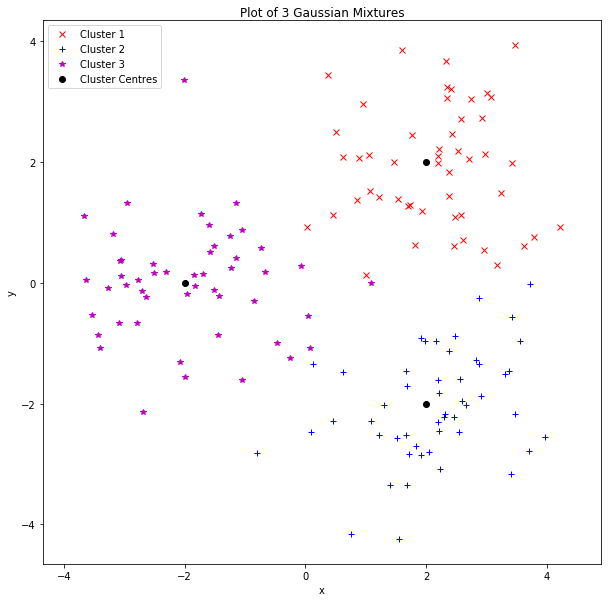

In [3]:
# Plot mixtures for sanity check
plt.figure(figsize=(10, 10))
plt.plot(x1, y1, 'rx', label='Cluster 1')
plt.plot(x2, y2, 'b+', label='Cluster 2')
plt.plot(x3, y3, 'm*', label='Cluster 3')
plt.plot(cluster_centres[0], cluster_centres[1], 'ko', label='Cluster Centres')
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.title('Plot of 3 Gaussian Mixtures')

In [4]:
# Set parameters for inference
k = len(cluster_centres[0])
pi_1 = pi_2 = pi_3 = 1/float(k)
pi = [pi_1, pi_2, pi_3]
print pi

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [5]:
# Concatentate inputs
cluster_1 = zip(x1, y1)
cluster_2 = zip(x2, y2)
cluster_3 = zip(x3, y3)
data = cluster_1 + cluster_2 + cluster_3
data = np.array(data)

In [6]:
# Initialise mu_hat
mu_hat_1 = [np.random.uniform(-0.05, 0.05), np.random.uniform(-0.05, 0.05)] 
mu_hat_2 = [np.random.uniform(-0.05, -0.05), np.random.uniform(-0.05, 0.05)] 
mu_hat_3 = [np.random.uniform(-0.05, -0.05), np.random.uniform(-0.05, 0.05)] 
mu_hat = [mu_hat_1, mu_hat_2, mu_hat_3]
mu_hat_1_collect= [mu_hat_1]
mu_hat_2_collect= [mu_hat_2]
mu_hat_3_collect= [mu_hat_3]
print mu_hat 

[[0.02766986680188714, 0.03009565143171143], [-0.05, -0.041510051796898734], [-0.05, 0.034520792586908]]


In [7]:
# Initialise z
z_hat = np.zeros(150, dtype=np.int8)
z_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [8]:
def compute_log_joint(mu, z, x):
    # Compute intial log joint
    term_1 = 0
    term_2 = 0
    term_3 = 0
    
    # Calculate first term
    for i in range(len(mu_hat)):
        term_1 += multivariate_normal.logpdf(mu_hat[i], [0, 0], cov)
    
    # Calculate second and third terms
    for j in range(len(data)):
        term_2 += np.log(pi[z[j]])
        # term_2 += bernoulli.logpmf(z[j], 0.5, loc=0)
        # print data[j], mu_hat[z[j]]
        term_3 += multivariate_normal.logpdf(data[j], mu_hat[z[j]], cov)
        
    return term_1 + term_2 + term_3

In [9]:
# Set convergence criteria
difference = 4 * (10 ** -2)

In [10]:
log_joint_old = compute_log_joint(mu_hat, z_hat, data)
log_joint_new = 0
log_joint_collect = [log_joint_old]

In [11]:
count = 0
# while count < 100:
start = time.clock()
while abs(log_joint_new - log_joint_old) > difference:
    # Sample zs
    for i in range(len(data)):
        # Faster
        log_prob_z_i = np.array(map(lambda pi_mu_hat: np.log(pi_mu_hat[0]) + multivariate_normal.logpdf(data[i], pi_mu_hat[1], cov), zip(pi, mu_hat)))
        log_normaliser = logsumexp(log_prob_z_i)
        log_prob_z_i = log_prob_z_i - log_normaliser
        # Slower
        # log_normaliser = logsumexp(map(lambda pi_mu_hat: np.log(pi_mu_hat[0]) + multivariate_normal.logpdf(data[i], pi_mu_hat[1], cov), zip(pi, mu_hat)))
        # log_prob_z_i = map(lambda pi_mu_hat: np.log(pi_mu_hat[0]) + multivariate_normal.logpdf(data[i], pi_mu_hat[1], cov) - log_normaliser, zip(pi, mu_hat))
        z_hat[i] = np.nonzero(multinomial(1, np.exp(log_prob_z_i)))[0][0]
    # print z_hat
    
    # Sample mu
    for j in range(len(mu_hat)):
        z_k = np.array([1 if z == j else 0 for z in z_hat])
        n_k = sum(z_k)
        mean_k = np.dot(z_k, data) * 1 / float(n_k)
        scale = n_k / float(n_k + 1)
        mu_hat[j] = np.random.multivariate_normal(scale * mean_k, float(n_k + 1) ** -1 * np.identity(2), 1)[0]
    # print mu_hat
    mu_hat_1_collect.append(mu_hat[0])
    mu_hat_2_collect.append(mu_hat[1])
    mu_hat_3_collect.append(mu_hat[2])
    log_joint_new = compute_log_joint(mu_hat, z_hat, data)
    log_joint_old = log_joint_collect[-1]
    log_joint_collect.append(log_joint_new)
    count += 1
    print count, abs(log_joint_new - log_joint_old)

end = time.clock()
print (end - start)
        

1 36.7640629005
2 66.1056835209
3 75.7291700902
4 89.7436012597
5 182.765355833
6 35.4239130527
7 4.56706024503
8 6.59394582578
9 3.5741244442
10 3.1994263235
11 0.457528727608
12 0.525613324374
13 3.55814505638
14 1.91696513829
15 1.91527029335
16 2.68729183883
17 3.76240447887
18 0.0448637234564
19 11.2148951361
20 14.7067563537
21 4.00728949222
22 5.49524173777
23 4.68690125875
24 0.334216526045
25 0.626709557161
26 0.606933294343
27 1.06875456816
28 3.73184552851
29 2.00319568279
30 4.87590405972
31 5.31280842556
32 0.87737313183
33 4.31698515961
34 1.11312149598
35 0.635872863064
36 1.00104158071
37 5.06423840776
38 1.38137058823
39 1.73602501289
40 7.34403171639
41 16.8136955722
42 6.52048553611
43 8.75366577668
44 2.95292829633
45 4.35969931478
46 2.46660309566
47 6.47902761605
48 9.37903847516
49 5.42494105885
50 5.26126070639
51 5.00624070584
52 1.28433902149
53 1.82941052991
54 3.79938655634
55 1.03078290705
56 2.30108839619
57 4.74740344541
58 1.12883255785
59 0.945667963215

Text(0.5,1,u'Log Joint against # Iterations')

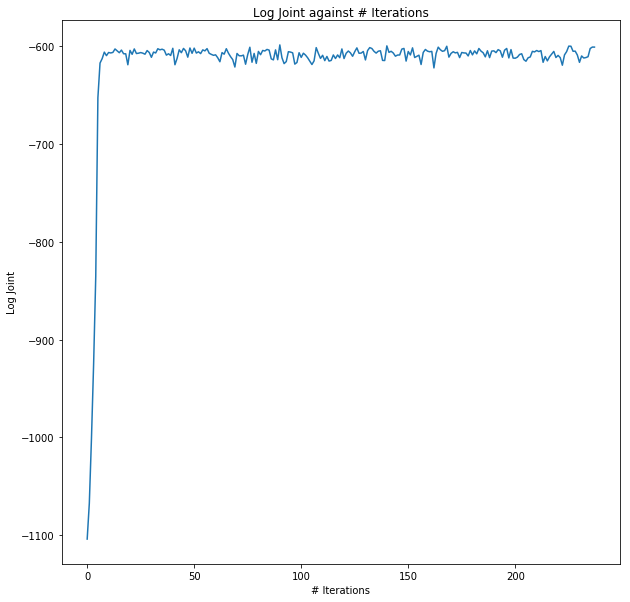

In [12]:
log_joint_x = range(len(log_joint_collect))
plt.figure(figsize=(10, 10))
plt.plot(log_joint_x, log_joint_collect)
plt.ylabel('Log Joint')
plt.xlabel('# Iterations')
plt.title('Log Joint against # Iterations')

Text(0.5,1,u'Movement of Cluster Centres')

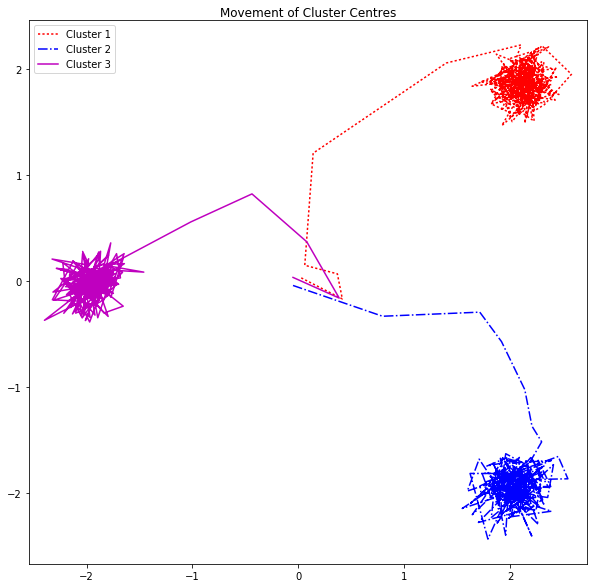

In [13]:
mu_hat_1_collect_x = []
mu_hat_1_collect_y = []
for i in mu_hat_1_collect:
    mu_hat_1_collect_x.append(i[0])
    mu_hat_1_collect_y.append(i[1])
    
mu_hat_2_collect_x = []
mu_hat_2_collect_y = []
for i in mu_hat_2_collect:
    mu_hat_2_collect_x.append(i[0])
    mu_hat_2_collect_y.append(i[1])
    
mu_hat_3_collect_x = []
mu_hat_3_collect_y = []
for i in mu_hat_3_collect:
    mu_hat_3_collect_x.append(i[0])
    mu_hat_3_collect_y.append(i[1])

plt.figure(figsize=(10, 10))    
plt.plot(mu_hat_1_collect_x, mu_hat_1_collect_y, 'r:', label='Cluster 1')
plt.plot(mu_hat_2_collect_x, mu_hat_2_collect_y, 'b-.', label='Cluster 2')
plt.plot(mu_hat_3_collect_x, mu_hat_3_collect_y, 'm-', label='Cluster 3')
plt.axis('equal')
plt.legend()
plt.title('Movement of Cluster Centres')

In [16]:
no_iterations = len(mu_hat_1_collect[50:])
print sum(mu_hat_1_collect[50:])/no_iterations, sum(mu_hat_2_collect[50:])/no_iterations, sum(mu_hat_3_collect[50:])/no_iterations

[ 2.11733163  1.85737745] [ 2.04162896 -1.93626671] [-1.95429518 -0.03094358]
